In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd 

from sklearn import decomposition
from sklearn import datasets
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import sklearn

In [3]:
Xo = pd.read_csv("data/credit/default_degree_labeled.csv", delimiter=",")

In [4]:
EDU_GRAD = 1
EDU_UNIVERSITY = 2
EDU_HIGHSCHOOL = 3
EDU_OTHER = 4


In [5]:
Xo

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [6]:
X = Xo.drop(["ID", "EDUCATION"], axis=1)

In [7]:
def normalize(x):
    return (x - x.mean()) / x.std()

In [9]:
X_nrm = normalize(X)

In [12]:
X_lowEd = X_nrm[(Xo.EDUCATION == EDU_OTHER) | (Xo.EDUCATION == EDU_HIGHSCHOOL)]
X_highEd = X_nrm[(Xo.EDUCATION == EDU_GRAD) | (Xo.EDUCATION == EDU_UNIVERSITY)]

In [22]:
A = X_lowEd - X_lowEd.mean()
B = X_highEd - X_highEd.mean()

In [8]:
def get_pca(X, n):
    pca = decomposition.PCA(n_components=n)
    pca.fit(X)
    return pca


def re(x_arr, pca):
    x_t = pca.transform(x_arr)
    x_reconst = pca.inverse_transform(x_t)
    err = np.sum((x_arr - x_reconst)**2, axis=1)
    return np.sum(err)


def reconstruction_error(x_arr, pca):
    return re(x_arr, pca) / len(x_arr)


def loss(x_group, x_all, n):
    """Computes reconstruction loss defined in (Samadi et al, 2018) definition 4.3
    
    Args:
        x_group (nd-array): protected group 
        x_all (nd-array): full population
        n (int): # params in PCA
    
    Returns:
        loss value, float
    """
    pca_all = get_pca(x_all, n)
    pca_group = get_pca(x_group, n)
    res = reconstruction_error(x_group, pca_all) - reconstruction_error(x_group, pca_group)
    assert res >= 0
    return res

Plot according to the Github repo of Samadi et al

In [26]:
recons_A = [reconstruction_error(A, get_pca(X_nrm, i)) for i in range(1,20)]
recons_B = [reconstruction_error(B, get_pca(X_nrm, i)) for i in range(1,20)]

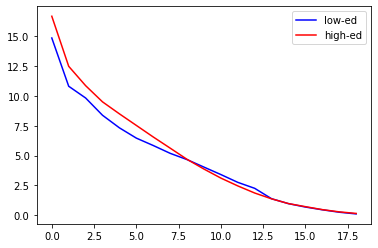

In [32]:
plt.figure(figsize=(6,4))
plt.cla()
plt.plot(recons_A, c='b', label='low-ed') # low education
plt.plot(recons_B, c='r', label='high-ed') #
# plt.plot([reconstruction_error(X_nrm, get_pca(X_nrm, i)) for i in range(1,20)], c='g')
plt.legend()
plt.show()

In [63]:
loss_A = [loss(A, X_nrm, i) for i in range(1,20)]
loss_B = [loss(B, X_nrm, i) for i in range(1,20)]

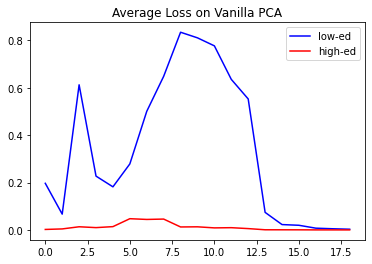

In [64]:
plt.figure(figsize=(6,4))
plt.cla()
plt.title("Average Loss on Vanilla PCA")
plt.plot(loss_A, c='b', label='low-ed') # low education
plt.plot(loss_B, c='r', label='high-ed') #
plt.legend()
plt.show()

The moving of the means for low-ed and high-ed does not make any sense, you can't just arbitrarily change the data

In [28]:
recons_A_nomove = [reconstruction_error(X_lowEd, get_pca(X_nrm, i)) for i in range(1,20)]
recons_B_nomove = [reconstruction_error(X_highEd, get_pca(X_nrm, i)) for i in range(1,20)]

In [30]:
len(A)

5040

In [31]:
len(B)

24615

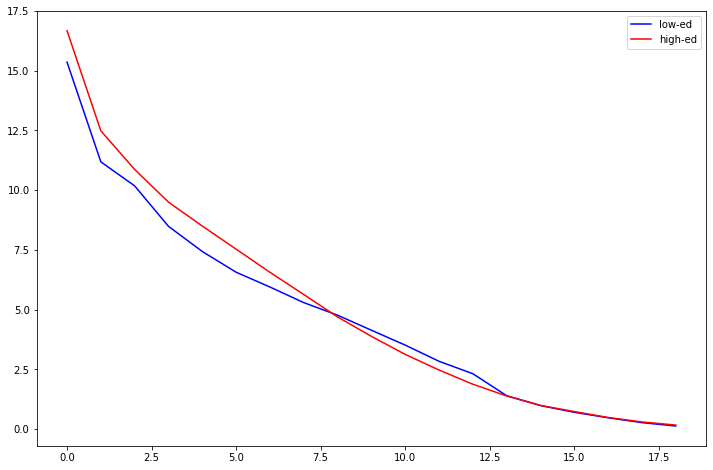

In [29]:
plt.figure(figsize=(12,8))
plt.cla()
plt.plot(recons_A_nomove, c='b', label='low-ed') # low education
plt.plot(recons_B_nomove, c='r', label='high-ed') #
# plt.plot([reconstruction_error(X_nrm, get_pca(X_nrm, i)) for i in range(1,20)], c='g')
plt.legend()
plt.show()

# Word to word

Translate the matlab functions in Samadi et al

In [58]:

def _re(Y, Z):
    from numpy.linalg import norm
    return norm(Y - Z, 'fro')**2

def _optApprox(Y, d):
    pca_Yhat = get_pca(Y, d)
    return pca_Yhat.inverse_transform(pca_Yhat.transform(Y))

def _reconstructBasedOn(X, pca):
    return pca.inverse_transform(pca.transform(X))

def _loss(Y, Z, d):
    Yhat = _optApprox(Y, d)
    loss = _re(Y, Z) - _re(Y, Yhat)
    return loss


In [60]:
loss_A = []
loss_B = []

for i in range(1, 22):
    pca = get_pca(X_nrm, i)
    approx_A = _reconstructBasedOn(A, pca)
    approx_B = _reconstructBasedOn(B, pca)
    tmp_loss_A = loss(A, approx_A, i) / A.shape[0]
    tmp_loss_B = loss(B, approx_B, i) / B.shape[0]
    loss_A.append(tmp_loss_A)
    loss_B.append(tmp_loss_B)

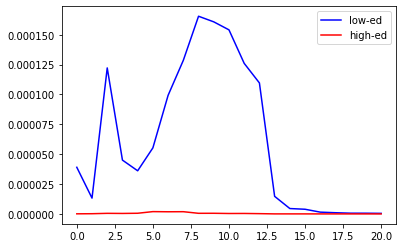

In [62]:
plt.figure(figsize=(6,4))
plt.cla()
plt.plot(loss_A, c='b', label='low-ed') # low education
plt.plot(loss_B, c='r', label='high-ed') #
plt.legend()
plt.show()

Still seems like there's a difference b/w this shape and the one in the publication

# Balanced

In [147]:
len(A)

5040

In [148]:
len(B)

24615

In [149]:
N = len(A)

In [150]:
Xr_lowEd = X[(Xo.EDUCATION == EDU_OTHER) | (Xo.EDUCATION == EDU_HIGHSCHOOL)]
Xr_highEd = X[(Xo.EDUCATION == EDU_GRAD) | (Xo.EDUCATION == EDU_UNIVERSITY)]

In [151]:
Xr_highEd_s = Xr_highEd.sample(N, replace=False)

In [152]:
X2 = Xr_lowEd.append(Xr_highEd_s)

In [153]:
X2_nrm = normalize(X2)
X2_lowEd = X2_nrm[:N]
X2_highEd = X2_nrm[N:]

In [154]:
A2 = X2_lowEd - X2_lowEd.mean()
B2 = X2_highEd - X2_highEd.mean()

In [155]:
loss_A2 = [loss(A2, X2_nrm, i) for i in range(1,20)]
loss_B2 = [loss(B2, X2_nrm, i) for i in range(1,20)]

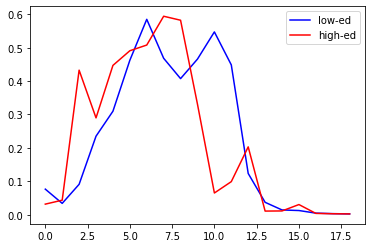

In [156]:
plt.figure(figsize=(6,4))
plt.cla()
plt.plot(loss_A2, c='b', label='low-ed') # low education
plt.plot(loss_B2, c='r', label='high-ed') #
plt.legend()
plt.show()

In [109]:
len(Xr_highEd)

24615

In [160]:
def tryout(Xo, seed=1):
    X = Xo.drop(["ID", "EDUCATION"], axis=1)
    Xr_lowEd = X[(Xo.EDUCATION == EDU_OTHER) | (Xo.EDUCATION == EDU_HIGHSCHOOL)]
    Xr_highEd = X[(Xo.EDUCATION == EDU_GRAD) | (Xo.EDUCATION == EDU_UNIVERSITY)]
    Xr_highEd_s = Xr_highEd.sample(N, replace=False, random_state=seed)
    X2 = Xr_lowEd.append(Xr_highEd_s)
    X2_nrm = normalize(X2)
    X2_lowEd = X2_nrm[:N]
    X2_highEd = X2_nrm[N:]
    A2 = X2_lowEd - X2_lowEd.mean()
    B2 = X2_highEd - X2_highEd.mean()
    loss_A2 = [loss(A2, X2_nrm, i) for i in range(1,20)]
    loss_B2 = [loss(B2, X2_nrm, i) for i in range(1,20)]
    plt.figure(figsize=(6,4))
    plt.cla()
    plt.plot(loss_A2, c='b', label='low-ed') # low education
    plt.plot(loss_B2, c='r', label='high-ed') #
    plt.legend()
    plt.show()
    

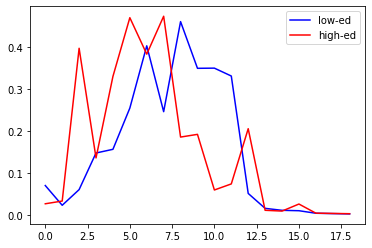

In [141]:
tryout(Xo, seed=2)

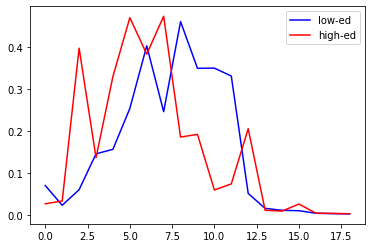

In [166]:
tryout(Xo, seed=2)

In [169]:
def tryout_arr(Xo, seed=1):
    X = Xo.drop(["ID", "EDUCATION"], axis=1)
    Xr_lowEd = X[(Xo.EDUCATION == EDU_OTHER) | (Xo.EDUCATION == EDU_HIGHSCHOOL)]
    Xr_highEd = X[(Xo.EDUCATION == EDU_GRAD) | (Xo.EDUCATION == EDU_UNIVERSITY)]
    Xr_highEd_s = Xr_highEd.sample(N, replace=False, random_state=seed)
    X2 = Xr_lowEd.append(Xr_highEd_s)
    X2_nrm = normalize(X2)
    X2_lowEd = X2_nrm[:N]
    X2_highEd = X2_nrm[N:]
    A2 = X2_lowEd - X2_lowEd.mean()
    B2 = X2_highEd - X2_highEd.mean()
    loss_A2 = [loss(A2, X2_nrm, i) for i in range(1,20)]
    loss_B2 = [loss(B2, X2_nrm, i) for i in range(1,20)]
    return loss_A2, loss_B2

In [179]:
a_agg = np.zeros(19)
b_agg = np.zeros(19)

for i in range(100):
    a, b = tryout_arr(Xo, seed=i)
    a_agg += a
    b_agg += b


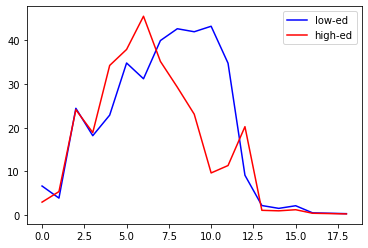

In [180]:
plt.cla()
plt.plot(a_agg, c='b', label='low-ed') # low education
plt.plot(b_agg, c='r', label='high-ed') #
plt.legend()
plt.show()

In [181]:
a_agg_2 = np.zeros(19)
b_agg_2 = np.zeros(19)

for i in range(1000):
    a, b = tryout_arr(Xo, seed=i)
    a_agg_2 += a
    b_agg_2 += b


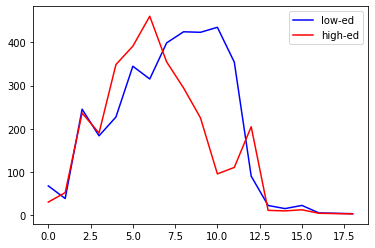

In [183]:
plt.cla()
plt.plot(a_agg_2, c='b', label='low-ed') # low education
plt.plot(b_agg_2, c='r', label='high-ed') #
plt.legend()
plt.show()

We can hence confirm that the difference in RE of low and high education is due to nothing other than more representation in the dataset. This is hardly a matter of unfairness as illustrated by Samadi et al.


<img width="400" src="https://d1yn1kh78jj1rr.cloudfront.net/image/preview/rDtN98Qoishumwih/swirl-design-separator_M1fewjtO_SB_PM.jpg"/>

# Random Forest

In [9]:
Xo

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [10]:
Xo_rnd = sklearn.utils.shuffle(Xo)

split into test and train

In [13]:
test_cut = 2 * Xo_rnd.shape[0] // 3
train_set = Xo_rnd.iloc[:test_cut,:]
test_set = Xo_rnd.iloc[test_cut:,:]

is_lowEd = lambda x: (x.EDUCATION == EDU_OTHER) | (x.EDUCATION == EDU_HIGHSCHOOL)
is_highEd = lambda x: (x.EDUCATION == EDU_GRAD) | (x.EDUCATION == EDU_UNIVERSITY)

test_set_lowEd = test_set[is_lowEd(test_set)]
test_set_highEd = test_set[is_highEd(test_set)]


In [14]:
x_of = lambda x: x.drop(["ID", "EDUCATION", "TARGET"], axis=1)
y_of = lambda x: x["TARGET"]


X_train, y_train = x_of(train_set), y_of(train_set)
X_test_lowEd, y_test_lowEd = x_of(test_set_lowEd), y_of(test_set_lowEd)
X_test_highEd, y_test_highEd = x_of(test_set_highEd), y_of(test_set_highEd)

Train random forest

In [16]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

Validate on lowEd and highEd

In [18]:
y_pred_lowEd = clf.predict(X_test_lowEd)
y_pred_highEd = clf.predict(X_test_highEd)

In [19]:
np.average(y_pred_lowEd == y_test_lowEd)

0.7820665083135392

In [21]:
np.average(y_pred_highEd == y_test_highEd)

0.817117776152158

In [29]:
def run_rf_experiment(Xo):
    
    Xo_rnd = sklearn.utils.shuffle(Xo)
    test_cut = 2 * Xo_rnd.shape[0] // 3
    train_set = Xo_rnd.iloc[:test_cut,:]
    test_set = Xo_rnd.iloc[test_cut:,:]

    is_lowEd = lambda x: (x.EDUCATION == EDU_OTHER) | (x.EDUCATION == EDU_HIGHSCHOOL)
    is_highEd = lambda x: (x.EDUCATION == EDU_GRAD) | (x.EDUCATION == EDU_UNIVERSITY)

    test_set_lowEd = test_set[is_lowEd(test_set)]
    test_set_highEd = test_set[is_highEd(test_set)]
    
    x_of = lambda x: x.drop(["ID", "EDUCATION", "TARGET"], axis=1)
    y_of = lambda x: x["TARGET"]

    X_train, y_train = x_of(train_set), y_of(train_set)
    X_test_lowEd, y_test_lowEd = x_of(test_set_lowEd), y_of(test_set_lowEd)
    X_test_highEd, y_test_highEd = x_of(test_set_highEd), y_of(test_set_highEd)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    y_pred_lowEd = clf.predict(X_test_lowEd)
    y_pred_highEd = clf.predict(X_test_highEd)
    
    history = (y_pred_lowEd, y_pred_highEd, y_test_lowEd, y_test_highEd)
    
    return np.average(y_pred_lowEd == y_test_lowEd), np.average(y_pred_highEd == y_test_highEd), history

In [30]:
exp_results = [run_rf_experiment(Xo) for _ in range(20)]

In [50]:
avg_acc_lowEd = np.average([x[0] for x in exp_results])
avg_acc_highEd = np.average([x[1] for x in exp_results])

In [46]:
fpr = lambda actual, pred: np.average((actual == 0) & (pred == 1))
fnr = lambda actual, pred: np.average((actual == 1) & (pred == 0))

In [47]:
avg_fpr_lowEd = np.average([fpr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])
avg_fnr_lowEd = np.average([fnr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])

avg_fpr_highEd = np.average([fpr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])
avg_fnr_highEd = np.average([fnr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])


In [201]:
def dump(*args):
    for i in args:
        print(i, "%.02f%%" % (eval(i) * 100))

In [56]:
dump("avg_fpr_lowEd", "avg_fnr_lowEd", "avg_fpr_highEd", "avg_fnr_highEd", "avg_acc_lowEd", "avg_acc_highEd")

avg_fpr_lowEd 5.82%
avg_fnr_lowEd 14.86%
avg_fpr_highEd 4.23%
avg_fnr_highEd 13.79%
avg_acc_lowEd 79.32%
avg_acc_highEd 81.98%


In [33]:
y_pred_lowEd, y_pred_highEd, y_test_lowEd, y_test_highEd = exp_results[0][2]

In [36]:
y_actual, y_pred = y_test_lowEd, y_pred_lowEd

In [43]:
np.average((y_actual == 0) & (y_pred == 1))

0.06005665722379604

In [45]:
np.average((y_actual == 1) & (y_pred == 0))

0.14220963172804532

# PCA - RandomForest 

In [21]:
Xo

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [22]:
X = normalize(Xo.drop(["ID", "EDUCATION", "TARGET"], axis=1))

pca = get_pca(X, n=10)
X_p = pca.transform(X)

X_p = pd.concat([pd.DataFrame(X_p), Xo["EDUCATION"], Xo["TARGET"]], axis=1)

X_p

,0,1,2,3,4,5,6,7,8,9,EDUCATION,TARGET
0,-1.894360,-0.880565,-0.646041,-0.364427,0.825343,-0.310963,-0.001634,0.034924,-0.271489,0.242224,2,1
1,-0.771761,-2.109515,0.705182,-1.062620,0.798236,-0.054338,0.120346,-0.175394,0.159669,0.142466,2,1
2,-0.853065,-1.060003,0.167405,-0.714842,0.626060,-0.043981,-0.113429,-0.107928,0.062377,0.046088,2,0
3,-0.203111,-0.784055,-0.526760,0.622562,1.020218,0.199193,-0.046492,0.087299,-0.085278,0.021001,2,0
4,-0.847140,-0.030879,0.348806,2.558250,-1.011589,1.027482,0.141751,0.548849,-0.301955,1.035960,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2.496777,0.828529,-0.974059,0.834042,-1.013579,0.555634,-0.753341,0.396866,-0.479821,0.208317,3,0
29996,-1.802925,0.088260,0.118167,0.153174,-1.387879,0.562522,0.134437,0.073367,0.466446,0.086797,3,0
29997,0.346745,-3.311918,0.745085,0.134661,-1.498269,-0.293887,0.581490,-0.225381,0.797873,0.170843,2,1
29998,0.623677,0.865436,2.176102,1.591926,-1.021344,-0.310594,-1.149540,2.213309,-1.274266,-4.265620,3,1


In [23]:
test_cut = 2 * X_p.shape[0] // 3
train_set = X_p.iloc[:test_cut,:]
test_set = X_p.iloc[test_cut:,:]

is_lowEd = lambda x: (x.EDUCATION == EDU_OTHER) | (x.EDUCATION == EDU_HIGHSCHOOL)
is_highEd = lambda x: (x.EDUCATION == EDU_GRAD) | (x.EDUCATION == EDU_UNIVERSITY)

test_set_lowEd = test_set[is_lowEd(test_set)]
test_set_highEd = test_set[is_highEd(test_set)]

In [24]:
x_of = lambda x: x.drop(["EDUCATION", "TARGET"], axis=1)
y_of = lambda x: x["TARGET"]

X_train, y_train = x_of(train_set), y_of(train_set)
X_test_lowEd, y_test_lowEd = x_of(test_set_lowEd), y_of(test_set_lowEd)
X_test_highEd, y_test_highEd = x_of(test_set_highEd), y_of(test_set_highEd)

In [25]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
y_pred_lowEd = clf.predict(X_test_lowEd)
y_pred_highEd = clf.predict(X_test_highEd)

history = (y_pred_lowEd, y_pred_highEd, y_test_lowEd, y_test_highEd)

In [27]:
np.average(y_pred_lowEd == y_test_lowEd), np.average(y_pred_highEd == y_test_highEd)

(0.78515625, 0.8206433983356105)

In [197]:
def run_pca_rf_experiment(Xo, d=10):
    
    X = normalize(Xo.drop(["ID", "EDUCATION", "TARGET"], axis=1))

    pca = get_pca(X, n=d)
    X_p = pca.transform(X)

    X_p = pd.concat([pd.DataFrame(X_p), Xo["EDUCATION"], Xo["TARGET"]], axis=1)

    test_cut = 2 * X_p.shape[0] // 3
    train_set = X_p.iloc[:test_cut,:]
    test_set = X_p.iloc[test_cut:,:]

    is_lowEd = lambda x: (x.EDUCATION == EDU_OTHER) | (x.EDUCATION == EDU_HIGHSCHOOL)
    is_highEd = lambda x: (x.EDUCATION == EDU_GRAD) | (x.EDUCATION == EDU_UNIVERSITY)

    test_set_lowEd = test_set[is_lowEd(test_set)]
    test_set_highEd = test_set[is_highEd(test_set)]
    
    x_of = lambda x: x.drop(["EDUCATION", "TARGET"], axis=1)
    y_of = lambda x: x["TARGET"]

    X_train, y_train = x_of(train_set), y_of(train_set)
    X_test_lowEd, y_test_lowEd = x_of(test_set_lowEd), y_of(test_set_lowEd)
    X_test_highEd, y_test_highEd = x_of(test_set_highEd), y_of(test_set_highEd)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    y_pred_lowEd = clf.predict(X_test_lowEd)
    y_pred_highEd = clf.predict(X_test_highEd)

    history = (y_pred_lowEd, y_pred_highEd, y_test_lowEd, y_test_highEd)
    
    acc_low_ed = np.average(y_pred_lowEd == y_test_lowEd)
    acc_high_ed = np.average(y_pred_highEd == y_test_highEd)
    
    return acc_low_ed, acc_high_ed, history

In [37]:
exp_results = [run_pca_rf_experiment(Xo) for _ in range(20)]

In [199]:
fpr = lambda actual, pred: np.average((actual == 0) & (pred == 1))
fnr = lambda actual, pred: np.average((actual == 1) & (pred == 0))

In [39]:
avg_acc_lowEd = np.average([x[0] for x in exp_results])
avg_acc_highEd = np.average([x[1] for x in exp_results])

In [40]:
avg_fpr_lowEd = np.average([fpr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])
avg_fnr_lowEd = np.average([fnr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])

avg_fpr_highEd = np.average([fpr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])
avg_fnr_highEd = np.average([fnr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])


In [43]:
dump("avg_fpr_lowEd", "avg_fnr_lowEd", "avg_fpr_highEd", "avg_fnr_highEd", "avg_acc_lowEd", "avg_acc_highEd")

avg_fpr_lowEd 5.10%
avg_fnr_lowEd 15.92%
avg_fpr_highEd 3.71%
avg_fnr_highEd 14.20%
avg_acc_lowEd 78.98%
avg_acc_highEd 82.10%


I made a mistake, it should be randomized

In [212]:
Xo_rnd = sklearn.utils.shuffle(Xo)

exp_results = [run_pca_rf_experiment(Xo_rnd) for _ in range(20)]

avg_acc_lowEd = np.average([x[0] for x in exp_results])
avg_acc_highEd = np.average([x[1] for x in exp_results])

avg_fpr_lowEd = np.average([fpr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])
avg_fnr_lowEd = np.average([fnr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])
avg_fpr_highEd = np.average([fpr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])
avg_fnr_highEd = np.average([fnr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])

dump("avg_fpr_lowEd", "avg_fnr_lowEd", "avg_fpr_highEd", "avg_fnr_highEd", "avg_acc_lowEd", "avg_acc_highEd")

avg_fpr_lowEd 0.86%
avg_fnr_lowEd 22.92%
avg_fpr_highEd 0.76%
avg_fnr_highEd 20.27%
avg_acc_lowEd 76.22%
avg_acc_highEd 78.97%


<img width="400" src="https://d1yn1kh78jj1rr.cloudfront.net/image/preview/rDtN98Qoishumwih/swirl-design-separator_M1fewjtO_SB_PM.jpg"/>

# Fair PCA

In [91]:
from numpy import linalg as LA

In [153]:
from scipy.linalg import sqrtm

In [98]:
def optApprox(M, d):
    pca = decomposition.PCA(n_components=d)
    pca.fit(M)
    return pca.transform(M)

In [12]:
X = normalize(Xo.drop(["ID", "EDUCATION", "TARGET"], axis=1))

In [30]:
is_lowEd = lambda x: (x.EDUCATION == EDU_OTHER) | (x.EDUCATION == EDU_HIGHSCHOOL)
is_highEd = lambda x: (x.EDUCATION == EDU_GRAD) | (x.EDUCATION == EDU_UNIVERSITY)

A = X[is_lowEd(Xo)].values
B = X[is_highEd(Xo)].values

In [131]:
# covA = np.dot(A.T, A)
# covB = np.dot(B.T, B)

# w_1 = 0.5
# w_2 = 0.5

# m_A = A.shape[0]
# m_B = B.shape[0]

# o1 = np.sqrt(w_1/m_A) * A
# o2 = np.sqrt(w_2/m_B) * B

# o = np.concatenate([o1, o2], axis=0)

# coeff_P_o = get_pca(o, n=10).components_.T

# P_o = np.dot(coeff_P_o, coeff_P_o.T)
# z_1 = (1/m_A) * (alpha - np.sum(np.multiply(covA, P_o)))
# z_2 = (1/m_B) * (beta - np.sum(np.multiply(covB, P_o)))

In [173]:
def oracle(n, A, m_A, B, m_B, alpha, beta, d, w_1, w_2):
    if A.shape != (m_A, n) or B.shape != (m_B, n):
        raise "Input has wrong size"
    
    covA = np.dot(A.T, A)
    covB = np.dot(B.T, B)
    
    o1 = np.sqrt(w_1/m_A) * A
    o2 = np.sqrt(w_2/m_B) * B

    o = np.concatenate([o1, o2], axis=0)

    coeff_P_o = get_pca(o, n=10).components_.T

    P_o = np.dot(coeff_P_o, coeff_P_o.T)
    z_1 = (1/m_A) * (alpha - np.sum(np.multiply(covA, P_o)))
    z_2 = (1/m_B) * (beta - np.sum(np.multiply(covB, P_o)))
    
    return P_o, z_1, z_2, coeff_P_o

In [207]:
from IPython.display import display, HTML

def mw(A, B, d, eta, T):
    
    covA = np.dot(A.transpose(), A)
    covB = np.dot(B.transpose(), B)
    
    m_A = A.shape[0]
    m_B = B.shape[0]
    n = A.shape[1]
    
    Ahat = optApprox(A, d)
    alpha = LA.norm(Ahat, 'fro') ** 2
    
    Bhat = optApprox(B, d)
    beta = LA.norm(Bhat, 'fro') ** 2
    
    w_1 = 0.5
    w_2 = 0.5
    
    P = np.zeros([n, n])
    cP = np.zeros([n, d])
    
    record = [("iteration", "w_1", "w_2", "loss A", "loss B", "loss A by average", "loss B by average")];
    
    for t in range(1, T + 1):
        P_temp, z_1, z_2, cP_temp = oracle(n, A, m_A, B, m_B, alpha, beta, d, w_1, w_2)
        
        w_1star = w_1 * np.exp(eta * z_1)
        w_2star = w_2 * np.exp(eta * z_2)
        
        w_1 = w_1star / (w_1star + w_2star)
        w_2 = w_2star / (w_2star + w_1star)
        
        P = P + P_temp
        cP = cP + cP_temp
        
        P_average = P / t
        
        record.append((t, w_1, w_2, z_1, z_2, (1/m_A)*(alpha - np.sum(np.multiply(covA, P_average))), (1/m_B)*(beta - np.sum(np.multiply(covB, P_average)))))
    
    P = P/T
    cP = cP/T
    
    z_1 = 1/(m_A)*(alpha - np.sum(np.multiply(covA, P)))
    z_2 = 1/(m_B)*(beta - np.sum(np.multiply(covB, P)))
    z = max(z_1,z_2);
    
    P_last = P_temp
    cP_last = cP_temp
    
    zl_1 = 1/(m_A)*(alpha - np.sum(np.multiply(covA, P_last)))
    zl_2 = 1/(m_B)*(beta - np.sum(np.multiply(covB, P_last)))
    z_last = max(zl_1,zl_2)
    
    print("Done")
    print('MW method is finished. The loss for group A is ', z_1, 'For group B is ', z_2)
    print("Record:")
    
    for r in record: 
        print("\t\t\t".join([str(rr) for rr in r]))
    
    return P_last, z, P, z_last, cP, cP_last


In [185]:
LA.norm(A - A @ coeff_A[:,:3] @ coeff_A[:,:3].T)

204.9708530345099

In [186]:
LA.norm(A - approx(A, get_pca(A, 3)))

204.09460652321528

In [187]:
def fairPCA(A, B, d):
    
    T = 10
    eta = 1
    feature_num = A.shape[1]
    
    P_fair, z, P_last, z_last, cP_fair, cP_last = mw(A, B, d, eta, T)
    
    if z < z_last:
        P_smart = P_fair
        cP_smart = cP_fair
    else:
        P_smart = P_last
        cP_smart = cP_last
    
    P_smart = np.eye(P_smart.shape[0]) - sqrtm(np.eye(P_smart.shape[0]) - P_smart)
    
    approxFair_A = A @ P_smart;
    approxFair_B = B @ P_smart;
    
    return approxFair_A, approxFair_B, P_smart, cP_smart


In [188]:
approxFair_A, approxFair_B, P_smart, cP_smart = fairPCA(A, B, 10)

Done
MW method is finished. The loss for group A is  0.07629710947008529 For group B is  0.13692378139464975
Record:
iteration	w_1	w_2	loss A	loss B	loss A by average	loss B by average
1	0.39802408727952676	0.6019759127204731	-0.11953946044518994	0.29416544771492986	-0.11953946044518994	0.29416544771492986
2	0.376008364231138	0.623991635768862	0.053531095567239624	0.14635176303209166	-0.033004182438976605	0.22025860537351197
3	0.36463739711029997	0.6353626028897	0.08056655505504692	0.1293334162941967	0.004852730059030278	0.18995020901373783
4	0.3587077125642549	0.6412922874357452	0.0951161131003039	0.12080113012501845	0.027418575819348687	0.17266293929155976
5	0.35568971458325715	0.6443102854167428	0.10312892502165813	0.11627312830863606	0.042560645659810575	0.16138497709497454
6	0.3542014773277426	0.6457985226722573	0.10740360001999805	0.11390361734664511	0.05336780471984278	0.15347141713691806
7	0.35348533748280847	0.6465146625171915	0.10957787088617994	0.11271006782804889	0.06139781

In [194]:
LA.norm(A - A @ cP_smart @ cP_smart.T)

128.5990829837401

In [195]:
LA.norm(A - A @ coeff_A[:,:10] @ coeff_A[:,:3].T)

116.170153919192

In [189]:
cP_smart.shape

(22, 10)

In [158]:
approxFair_A.shape

(5040, 22)

In [208]:
def run_fair_pca_rf_experiment(Xo, d=10):
    
    X = normalize(Xo.drop(["ID", "EDUCATION", "TARGET"], axis=1))
    
    # Utility functions for selecting high education and low education
    is_lowEd = lambda x: (x.EDUCATION == EDU_OTHER) | (x.EDUCATION == EDU_HIGHSCHOOL)
    is_highEd = lambda x: (x.EDUCATION == EDU_GRAD) | (x.EDUCATION == EDU_UNIVERSITY)
    
    # Fair PCA requires division by the protected groups
    A = X[is_lowEd(Xo)].values
    B = X[is_highEd(Xo)].values
    
    # Convert to Fair PCA low-dim space
    _, _, _, coff_P = fairPCA(A, B, d)
    X_p = X @ coff_P
    
#     pca = get_pca(X, n=10)
#     X_p = pca.transform(X)

    X_p = pd.concat([pd.DataFrame(X_p), Xo["EDUCATION"], Xo["TARGET"]], axis=1)

    test_cut = 2 * X_p.shape[0] // 3
    train_set = X_p.iloc[:test_cut,:]
    test_set = X_p.iloc[test_cut:,:]
    
    test_set_lowEd = test_set[is_lowEd(test_set)]
    test_set_highEd = test_set[is_highEd(test_set)]
    
    x_of = lambda x: x.drop(["EDUCATION", "TARGET"], axis=1)
    y_of = lambda x: x["TARGET"]

    X_train, y_train = x_of(train_set), y_of(train_set)
    X_test_lowEd, y_test_lowEd = x_of(test_set_lowEd), y_of(test_set_lowEd)
    X_test_highEd, y_test_highEd = x_of(test_set_highEd), y_of(test_set_highEd)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    y_pred_lowEd = clf.predict(X_test_lowEd)
    y_pred_highEd = clf.predict(X_test_highEd)

    history = (y_pred_lowEd, y_pred_highEd, y_test_lowEd, y_test_highEd)
    
    acc_low_ed = np.average(y_pred_lowEd == y_test_lowEd)
    acc_high_ed = np.average(y_pred_highEd == y_test_highEd)
    
    return acc_low_ed, acc_high_ed, history

In [210]:
Xo_rnd = sklearn.utils.shuffle(Xo)

exp_results = [run_fair_pca_rf_experiment(Xo_rnd) for _ in range(20)]

avg_acc_lowEd = np.average([x[0] for x in exp_results])
avg_acc_highEd = np.average([x[1] for x in exp_results])

avg_fpr_lowEd = np.average([fpr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])
avg_fnr_lowEd = np.average([fnr(y_test_lowEd, y_pred_lowEd) for y_pred_lowEd, _, y_test_lowEd, _ in (x[2] for x in exp_results)])
avg_fpr_highEd = np.average([fpr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])
avg_fnr_highEd = np.average([fnr(y_test_highEd, y_pred_highEd) for _, y_pred_highEd, _, y_test_highEd in (x[2] for x in exp_results)])


Done
MW method is finished. The loss for group A is  0.07629710866450397 For group B is  0.13692378150204837
Record:
iteration			w_1			w_2			loss A			loss B			loss A by average			loss B by average
1			0.39802409165144925			0.6019759083485506			-0.11953945133191443			0.29416543858152006			-0.11953945133191443			0.29416543858152006
2			0.3760083659963512			0.6239916340036489			0.05353108910544145			0.14635176729346233			-0.03300418111323649			0.22025860293749003
3			0.3646373984935165			0.6353626015064836			0.08056655408337454			0.12933341687558753			0.004852730618967187			0.18995020758352252
4			0.3587077132372394			0.6412922867627606			0.09511611116310907			0.12080113123272099			0.027418575755002658			0.17266293849582331
5			0.3556897151783358			0.6443102848216643			0.10312892481074774			0.11627312842666414			0.04256064556614994			0.16138497648198866
6			0.35420147781983913			0.6457985221801609			0.1074035997321473			0.11390361750410256			0.05336780459381569			0.15347141665234135
7			0

Done
MW method is finished. The loss for group A is  0.07629710908879912 For group B is  0.13692378114445022
Record:
iteration			w_1			w_2			loss A			loss B			loss A by average			loss B by average
1			0.3980240931109747			0.6019759068890254			-0.11953944826989986			0.29416543555204955			-0.11953944826989986			0.29416543555204955
2			0.3760083670820121			0.6239916329179879			0.05353108822135197			0.14635176787366136			-0.033004180024273945			0.22025860171285427
3			0.364637399405543			0.635362600594457			0.08056655365126061			0.12933341713403995			0.004852731200902319			0.1899502068532487
4			0.35870771468055523			0.6412922853194447			0.09511611264840053			0.1208011303803518			0.027418576562781204			0.17266293773502567
5			0.3556897160191016			0.6443102839808984			0.10312892313671447			0.11627312935825156			0.0425606458775667			0.16138497605967272
6			0.35420147836777427			0.6457985216322257			0.10740359891083605			0.11390361795604137			0.05336780471644734			0.15347141637573022
7			0.35

Done
MW method is finished. The loss for group A is  0.07629710918067542 For group B is  0.13692378122840734
Record:
iteration			w_1			w_2			loss A			loss B			loss A by average			loss B by average
1			0.39802409154264357			0.6019759084573564			-0.11953945155937473			0.2941654388081717			-0.11953945155937473			0.2941654388081717
2			0.37600836675523247			0.6239916332447677			0.053531091325789426			0.14635176582526957			-0.033004180116794096			0.22025860231671945
3			0.3646373971912793			0.6353626028087207			0.08056654855251205			0.12933342020007144			0.0048527294396441744			0.18995020827783834
4			0.3587077126877434			0.6412922873122566			0.09511611321908392			0.12080113005651241			0.027418575384503388			0.17266293872250568
5			0.3556897153255637			0.6443102846744362			0.10312892675440144			0.11627312733915632			0.04256064565848242			0.16138497644583677
6			0.3542014775527434			0.6457985224472567			0.10740359856608847			0.11390361814813965			0.0533678044764158			0.1534714167295543
7			0

Done
MW method is finished. The loss for group A is  0.07629710929405042 For group B is  0.13692378116822276
Record:
iteration			w_1			w_2			loss A			loss B			loss A by average			loss B by average
1			0.3980240914470694			0.6019759085529306			-0.11953945175789865			0.29416543900853703			-0.11953945175789865			0.29416543900853703
2			0.37600836597087206			0.6239916340291279			0.053531089553669316			0.14635176699728314			-0.033004181102111785			0.22025860300291245
3			0.36463739878760354			0.6353626012123965			0.08056655494365836			0.1293334163578929			0.00485273091314397			0.18995020745456945
4			0.3587077134701082			0.6412922865298919			0.0951161109994058			0.12080113132608972			0.02741857593470726			0.1726629384224507
5			0.35568971549693407			0.644310284503066			0.1031289250522518			0.1162731282902811			0.04256064575821501			0.1613849763960144
6			0.35420147785490147			0.6457985221450986			0.10740359893467925			0.1139036179435509			0.05336780462096194			0.1534714166539399
7			0.35348

In [211]:
dump("avg_fpr_lowEd", "avg_fnr_lowEd", "avg_fpr_highEd", "avg_fnr_highEd", "avg_acc_lowEd", "avg_acc_highEd")

avg_fpr_lowEd 6.30%
avg_fnr_lowEd 14.65%
avg_fpr_highEd 4.81%
avg_fnr_highEd 14.41%
avg_acc_lowEd 79.05%
avg_acc_highEd 80.78%


With Fair PCA:

In [216]:
print("HighEd advantage FNR:", avg_fnr_highEd - avg_fnr_lowEd)
print("HighEd advantage FPR:", avg_fpr_highEd - avg_fpr_lowEd)
print("HighEd advantage ACC:", avg_acc_highEd - avg_acc_lowEd)

HighEd advantage FNR: -0.026539543668044757
HighEd advantage FPR: -0.00104189308781518
HighEd advantage ACC: 0.02758143675586011


In [2]:
sum([0.026539543668044757, 0.00104189308781518])/2

0.013790718377929969

In [5]:
hmean([0.026539543668044757, 0.00104189308781518])

0.002005070826894481

Without Normal PCA:

In [218]:
avg_fpr_lowEd = 5.10 * 0.01
avg_fnr_lowEd = 15.92* 0.01
avg_fpr_highEd = 3.71* 0.01
avg_fnr_highEd = 14.20* 0.01
avg_acc_lowEd = 78.98* 0.01
avg_acc_highEd = 82.10* 0.01

In [219]:
print("HighEd advantage FNR:", avg_fnr_highEd - avg_fnr_lowEd)
print("HighEd advantage FPR:", avg_fpr_highEd - avg_fpr_lowEd)
print("HighEd advantage ACC:", avg_acc_highEd - avg_acc_lowEd)

HighEd advantage FNR: -0.01720000000000002
HighEd advantage FPR: -0.013899999999999996
HighEd advantage ACC: 0.031199999999999894


In [3]:
sum([0.01720000000000002, 0.00104189308781518])/2

0.015550000000000008

In [4]:
from scipy.stats import hmean

In [6]:
hmean([0.01720000000000002, 0.00104189308781518])

0.001964769887001616

<img width="400" src="https://d1yn1kh78jj1rr.cloudfront.net/image/preview/rDtN98Qoishumwih/swirl-design-separator_M1fewjtO_SB_PM.jpg"/>